In [14]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import pandas as pd
import scipy
import csv

from src.poisson_process import NHPoissonProcess
from src.mcmc import PoissonMCMC
from src.visualisation import *
from parameters.params import Params
from src.densities import gpd_quantile
from src.rhat_infinity import *


In [15]:
from IPython.display import display


# Parameters loading


In [16]:
poisson_params_directory = "parameters/poisson_simu/"

# poisson_config = "sharkey_poisson_config"
# poisson_config = "tony_poisson_config"
poisson_config = "negative_xi_config"

poisson_params = Params(poisson_params_directory + poisson_config + ".json")

mcmc_params_directory = "parameters/mcmc/"
mcmc_configs = ["Config4.json", "Config5.json", "Config6.json"]

# mcmc_configs = []
# for filename in os.listdir(mcmc_params_directory):
#     if "json" in filename:
#         mcmc_configs.append(filename)

estimator = "mean"


# Data simulation

Poisson process parameter: (mu = 50, sigma = 15, xi = -0.25)
Orthogonal version: (r = 31.60, nu = 15.00, xi = -0.25)
Expected number of points: 31.60
Number of generated points: 28
Min: 31.222
Max: 68.930

Estimation of quantiles 1/31, 1/63 and 1/94 
Theoretical values of quantiles: 76.260, 81.628, 84.363


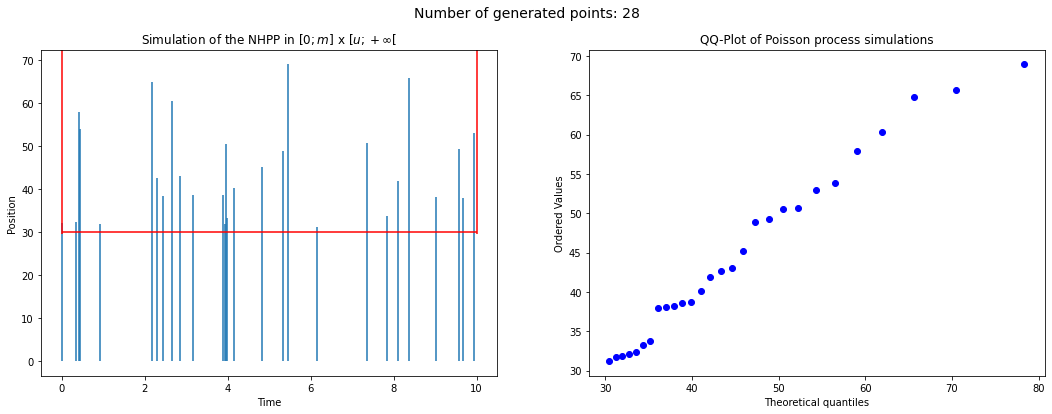

In [17]:
PP = NHPoissonProcess(mu=poisson_params.mu, sig=poisson_params.sigma, xi=poisson_params.xi,
                      u=poisson_params.u, m=poisson_params.m)

lam_obs = PP.get_measure()
n_obs = PP.gen_number_points()[0]

obs = PP.gen_positions(n_obs=n_obs)
times = PP.gen_time_events(n_obs=n_obs)

pp_params = PP.get_parameters()
print("Poisson process parameter: (mu = {}, sigma = {}, xi = {})".format(pp_params[2],
                                                                         pp_params[3],
                                                                         pp_params[4]))
ortho_params = PP.get_orthogonal_reparam()
print("Orthogonal version: (r = {:.2f}, nu = {:.2f}, xi = {})".format(ortho_params[0],
                                                                      ortho_params[1],
                                                                      ortho_params[2]))
print("Expected number of points: {:.2f}".format(lam_obs))
print("Number of generated points:", n_obs)
print("Min: {:.3f}".format(np.min(obs)))
print("Max: {:.3f}".format(np.max(obs)))

quantiles = (1/lam_obs, 1/(2*lam_obs), 1/(3*lam_obs))
print("\nEstimation of quantiles 1/{}, 1/{} and 1/{} ".format(int(lam_obs), int(2*lam_obs), int(3*lam_obs)))
sig_tilde = pp_params[3]+pp_params[4]*(pp_params[0]-pp_params[2])
real_q1 = gpd_quantile(prob=quantiles[0], mu=pp_params[0], sig=sig_tilde, xi=pp_params[4])
real_q2 = gpd_quantile(prob=quantiles[1], mu=pp_params[0], sig=sig_tilde, xi=pp_params[4])
real_q3 = gpd_quantile(prob=quantiles[2], mu=pp_params[0], sig=sig_tilde, xi=pp_params[4])
print("Theoretical values of quantiles: {:.3f}, {:.3f}, {:.3f}".format(real_q1, real_q2, real_q3))

PP.plot_simulation(times=times, positions=obs)


# MCMC


Config file:  Config4.json
Flat Prior on orthogonal parameters

Choice of m = 10 for MCMC

 Summary:
Multivariate R-hat-infinity on all dependence directions: 1.007 (threshold: 1.043)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat,r_threshold,r_hat_infty
r,41.136,6.503,29.880,54.103,0.189,0.134,1185.0,1185.0,1166.0,940.0,1.01,1.031,1.008
nu,14.490,2.117,10.911,18.666,0.065,0.048,1076.0,985.0,1182.0,889.0,1.00,1.031,1.004
xi,-0.130,0.173,-0.444,0.186,0.006,0.004,856.0,856.0,942.0,835.0,1.00,1.031,1.007


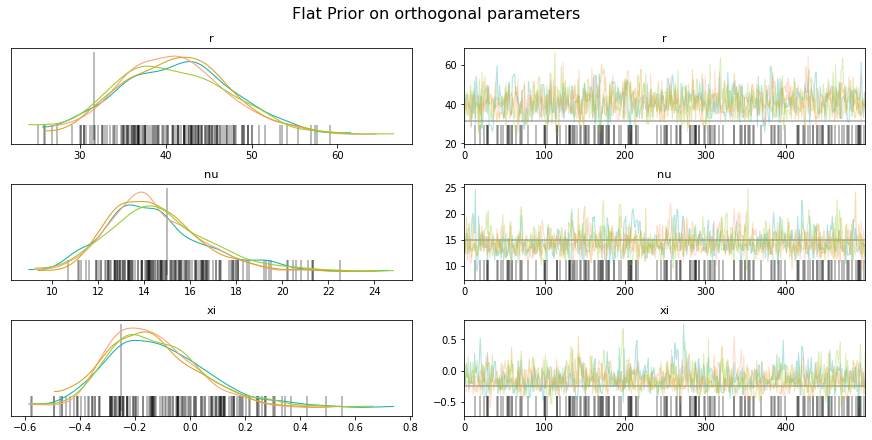


Config file:  Config5.json
Jeffreys prior on orthogonal parameters

Choice of m = 10 for MCMC

 Summary:
Multivariate R-hat-infinity on all dependence directions: 1.020 (threshold: 1.043)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat,r_threshold,r_hat_infty
r,42.631,6.526,30.915,55.055,0.206,0.146,1006.0,1006.0,1001.0,887.0,1.00,1.031,1.002
nu,14.381,2.263,10.586,18.502,0.118,0.089,370.0,324.0,511.0,325.0,1.01,1.031,1.032
xi,-0.177,0.170,-0.471,0.116,0.007,0.006,529.0,476.0,471.0,438.0,1.01,1.031,1.014


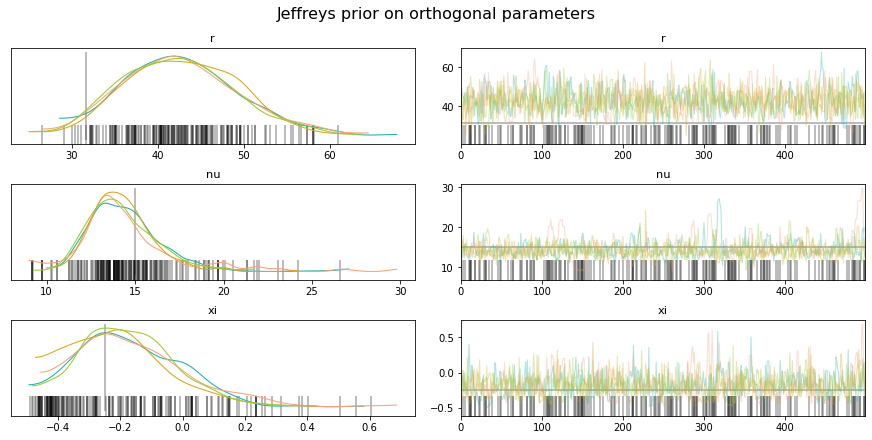


Config file:  Config6.json
Vague Prior on orthogonal parameters

Choice of m = 10 for MCMC

 Summary:
Multivariate R-hat-infinity on all dependence directions: 1.009 (threshold: 1.043)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat,r_threshold,r_hat_infty
r,42.034,6.490,29.728,53.653,0.148,0.105,1923.0,1923.0,1781.0,984.0,1.00,1.031,1.004
nu,14.073,1.828,10.847,17.347,0.051,0.037,1284.0,1196.0,1431.0,1051.0,1.01,1.031,1.006
xi,-0.129,0.173,-0.445,0.198,0.005,0.004,1321.0,866.0,1244.0,682.0,1.00,1.031,1.010


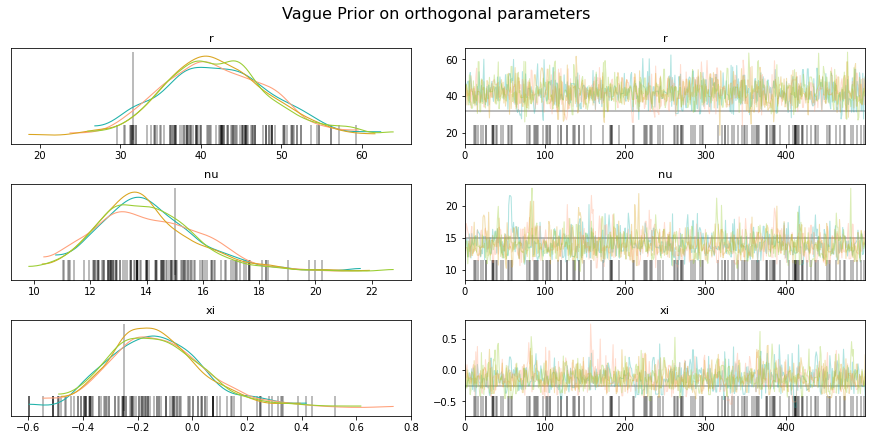

In [5]:
traces = []
traces_orthogonal = []
names = []
names_orthogonal = []

MCMC_list = []


for filename in mcmc_configs:
    print("\nConfig file: ", filename)
    mcmc_params = Params(mcmc_params_directory + filename)
    print(mcmc_params.name)
    print("")
    
    priors = [mcmc_params.priors["p1"],
              mcmc_params.priors["p2"],
              mcmc_params.priors["p3"]]

    if mcmc_params.init_p1_by_u:
        init_val = n_obs if mcmc_params.orthogonal_param else poisson_params.u
        priors[0] = priors[0].replace("u", str(init_val))

    MCMC = PoissonMCMC(priors=priors, step_method=mcmc_params.step_method, niter=mcmc_params.niter,
                       obs=obs, u=poisson_params.u, m=poisson_params.m, quantiles=quantiles,
                       orthogonal_param=mcmc_params.orthogonal_param)
    if mcmc_params.update_m != "":
        MCMC.update_m(update_arg=mcmc_params.update_m, xi=poisson_params.xi)
    print("Choice of m = {} for MCMC".format(MCMC.m))

    trace = MCMC.run(verbose=False)

    names.append(mcmc_params.name)
    traces.append(trace)
    
    MCMC_list.append(MCMC)
        
    print("\n Summary:")
    if MCMC.orthogonal_param:
        display(localrhat_summary(data=trace, var_names=["r", "nu", "xi"]))
        plot_trace(trace, var_names=["r", "nu", "xi"], title=mcmc_params.name, real_value=ortho_params[0:3])
    else:
        display(localrhat_summary(data=trace, var_names=["mu_m", "sig_m", "xi"]))
        plot_trace(trace, var_names=["mu_m", "sig_m", "xi"], title=mcmc_params.name, real_value=pp_params[2:5])
    plt.show()

    

## Prior Predictive check

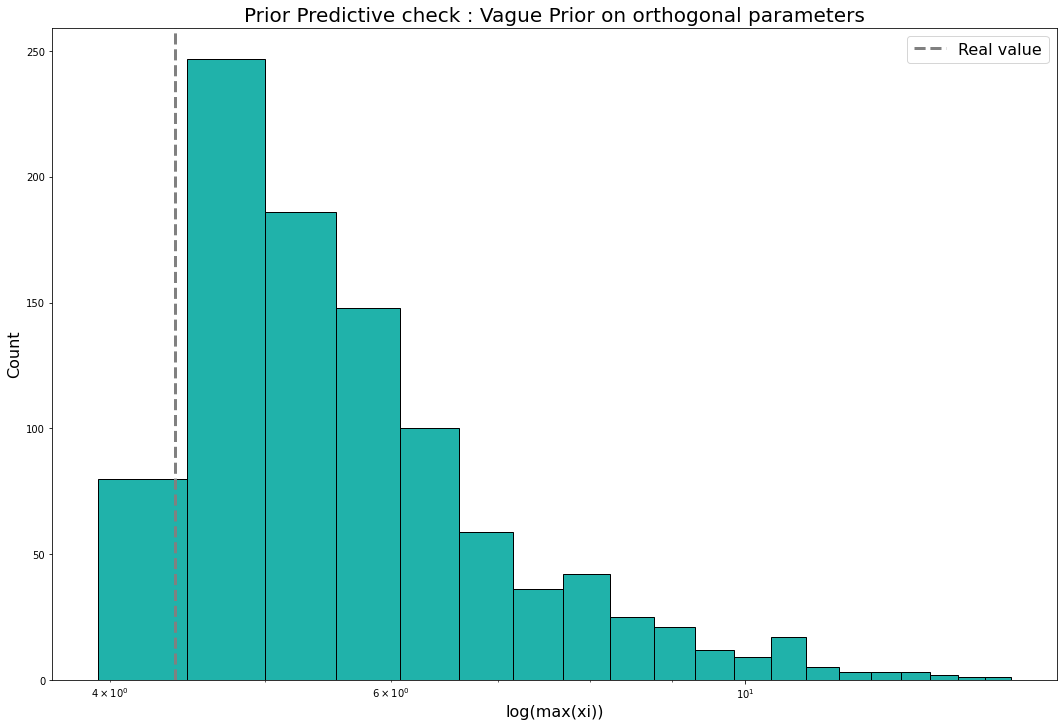

In [6]:
n_samples_ppc = 1000
M = MCMC_list[-1]
mcmc_params = Params(mcmc_params_directory + mcmc_configs[-1])


prior_pc = M.prior_predictive_check(nsamples=n_samples_ppc)

plt.figure(figsize=(18, 12))
plt.xscale("log")
plt.hist(np.log([max(dataset) for dataset in prior_pc["gpd"]]), bins = 20, 
         edgecolor='black', color = "lightseagreen")
plt.axvline(np.log(max(obs)), linestyle='dashed', color = "grey",
            linewidth=3, label = "Real value")
plt.title("Prior Predictive check : {}".format(mcmc_params.name), fontsize=20)
plt.xlabel('log(max(xi))', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.legend(fontsize=16)
plt.show()

## Posterior Predictive check

### Distribution of the Max

In [7]:
mu, sig, xi = pp_params[2], pp_params[3], pp_params[4]

def g(z, mu, sig, xi):
    return ((1/sig) * ((1 + xi * (z - mu) / sig) ** (-1 - (1/xi))) * \
             np.exp(-(1 + xi * (z - mu) / sig) ** (-1 / xi)))


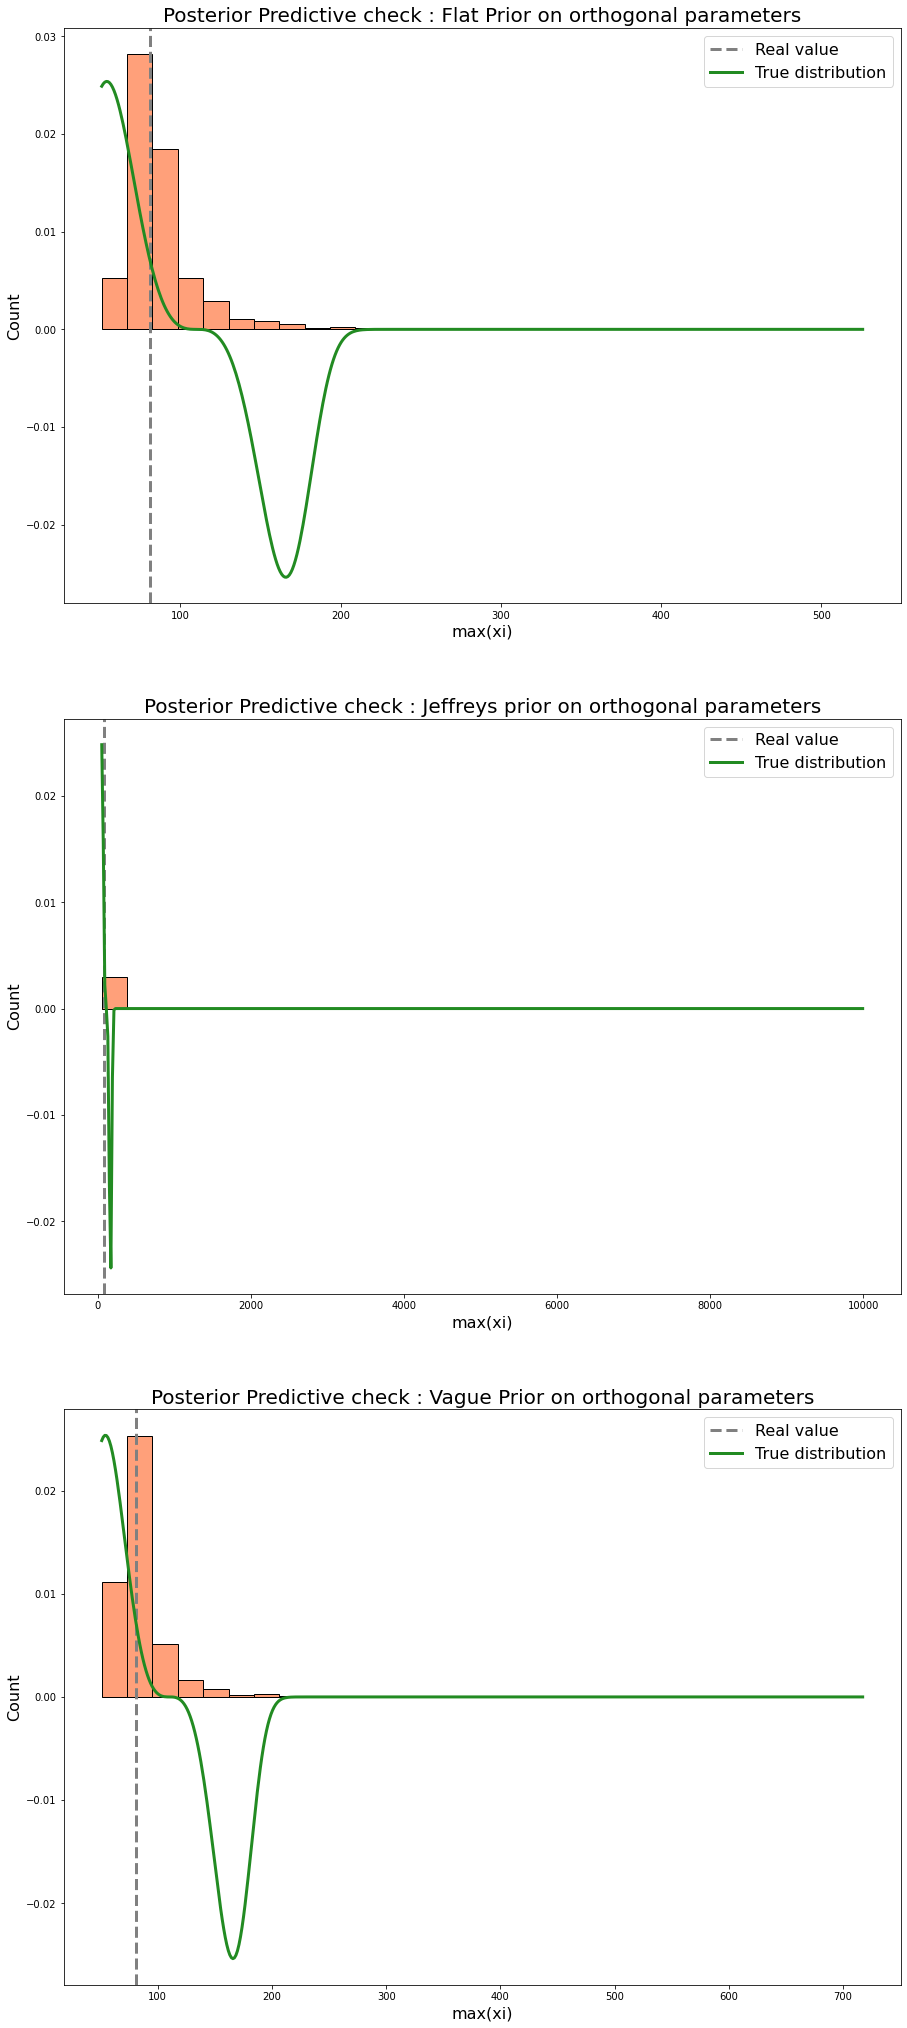

In [8]:
ppc_list = []

nb_traces = len(traces)
_, ax = plt.subplots(nb_traces, figsize=(15, nb_traces * 12))

for i, trace in enumerate(traces):
    mcmc_params = Params(mcmc_params_directory + mcmc_configs[i])

    ppc = MCMC.posterior_predictive_check(trace)
    ppc_list.append(ppc)

    post_pred_max = [max(dataset) for dataset in ppc["gpd"]]
    ax[i].hist(post_pred_max, bins = 30, density = True,
               edgecolor='black', color = "lightsalmon")
    
    ax[i].axvline(max(obs), linestyle='dashed', color = "grey",
                     linewidth=3, label = "Real value")
    
    z_range = np.linspace(min(post_pred_max), max(post_pred_max), 500)
    ax[i].plot(z_range, [g(z,mu,sig,xi) for z in z_range], color="forestgreen",
               linewidth = 3, label = "True distribution")
    
    ax[i].set_title("Posterior Predictive check : {}".format(mcmc_params.name), fontsize=20)
    ax[i].set_xlabel('max(xi)', fontsize=16)
    ax[i].set_ylabel('Count', fontsize=16)
    ax[i].legend(fontsize=16)
    
plt.show()
    

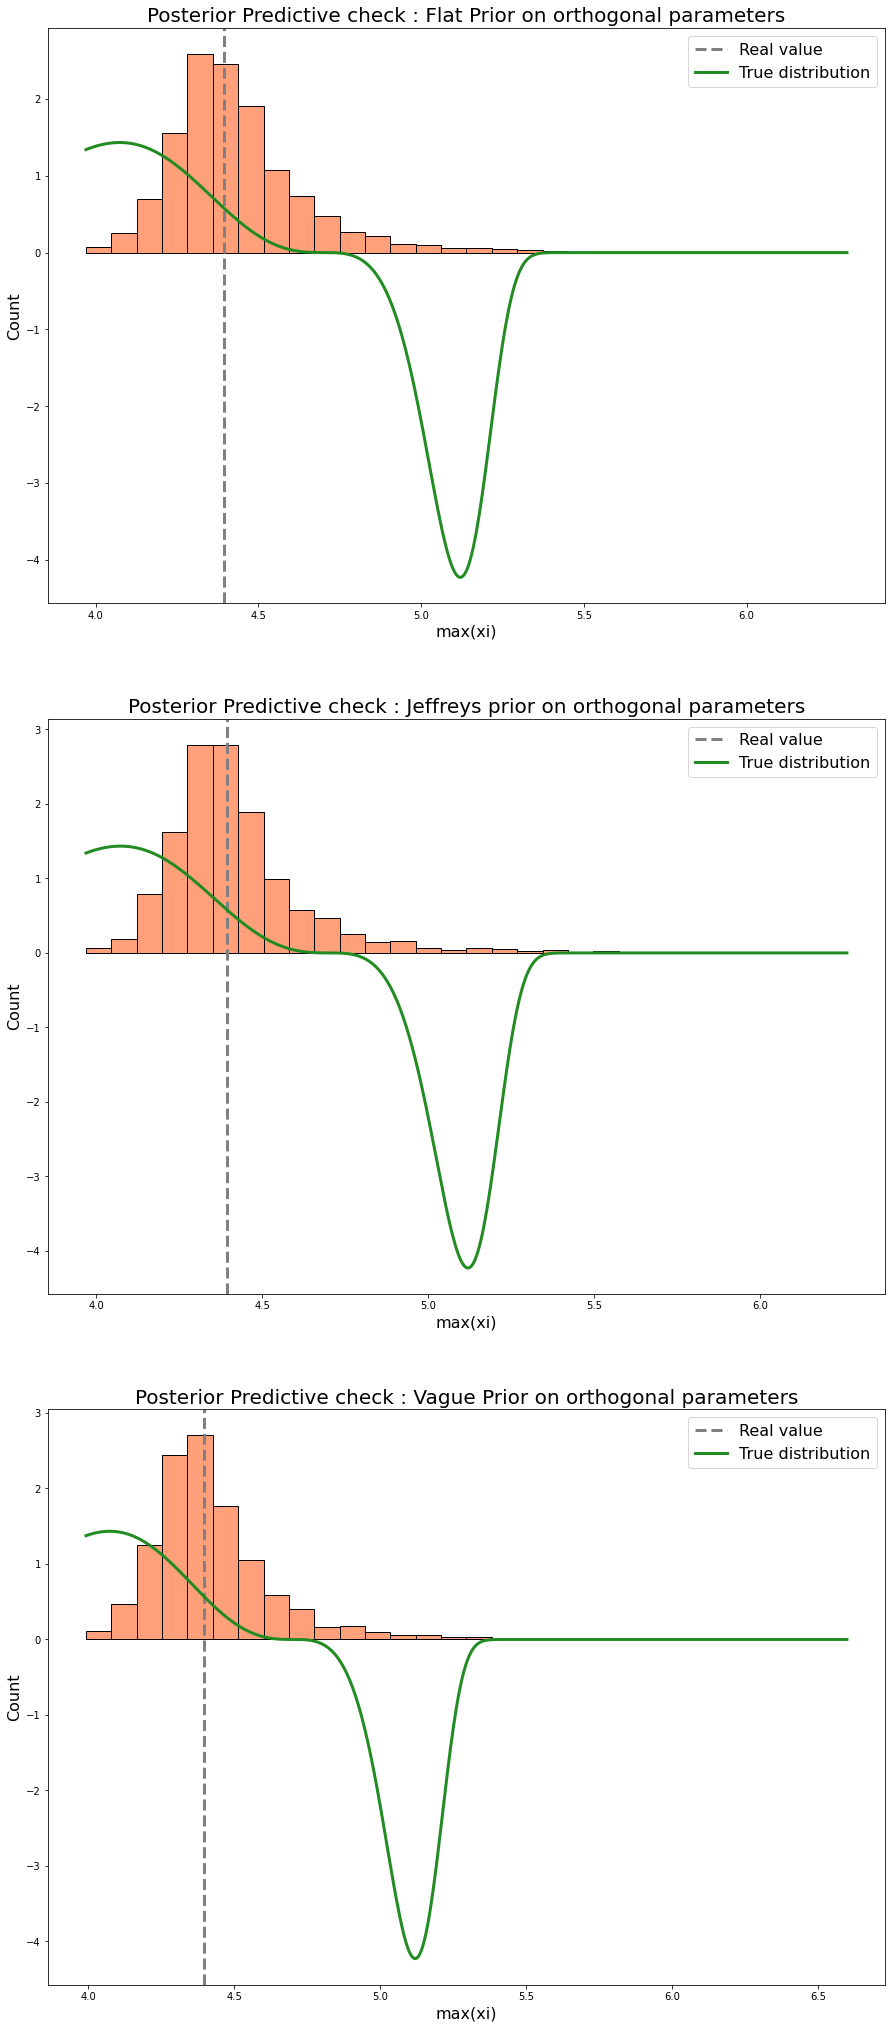

In [9]:
ppc_list = []

nb_traces = len(traces)
_, ax = plt.subplots(nb_traces, figsize=(15, nb_traces * 12))

for i, trace in enumerate(traces):
    mcmc_params = Params(mcmc_params_directory + mcmc_configs[i])

    ppc = MCMC.posterior_predictive_check(trace)
    ppc_list.append(ppc)

    
    post_pred_max = [np.log(max(dataset)) for dataset in ppc["gpd"]]
    ax[i].hist(post_pred_max, bins = 30, density = True,
               edgecolor='black', color = "lightsalmon")
    
    ax[i].axvline(np.log(max(obs)), linestyle='dashed', color = "grey",
                     linewidth=3, label = "Real value")
    
    z_range = np.linspace(min(post_pred_max), max(post_pred_max), 500)
    ax[i].plot(z_range, [np.exp(z)*g(np.exp(z),mu,sig,xi) for z in z_range], color="forestgreen",
               linewidth = 3, label = "True distribution")
    
    ax[i].set_title("Posterior Predictive check : {}".format(mcmc_params.name), fontsize=20)
    ax[i].set_xlabel('max(xi)', fontsize=16)
    ax[i].set_ylabel('Count', fontsize=16)
    ax[i].legend(fontsize=16)
    
plt.show()

### Histogram of the real dataset

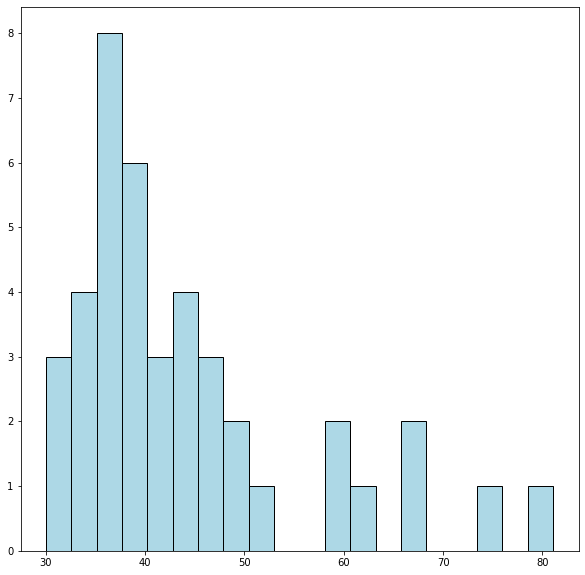

In [10]:
plt.figure(figsize=(10, 10))
plt.hist(obs, bins = 20, edgecolor='black', color = "lightblue")
plt.show()

### Comparison with generated datasets 

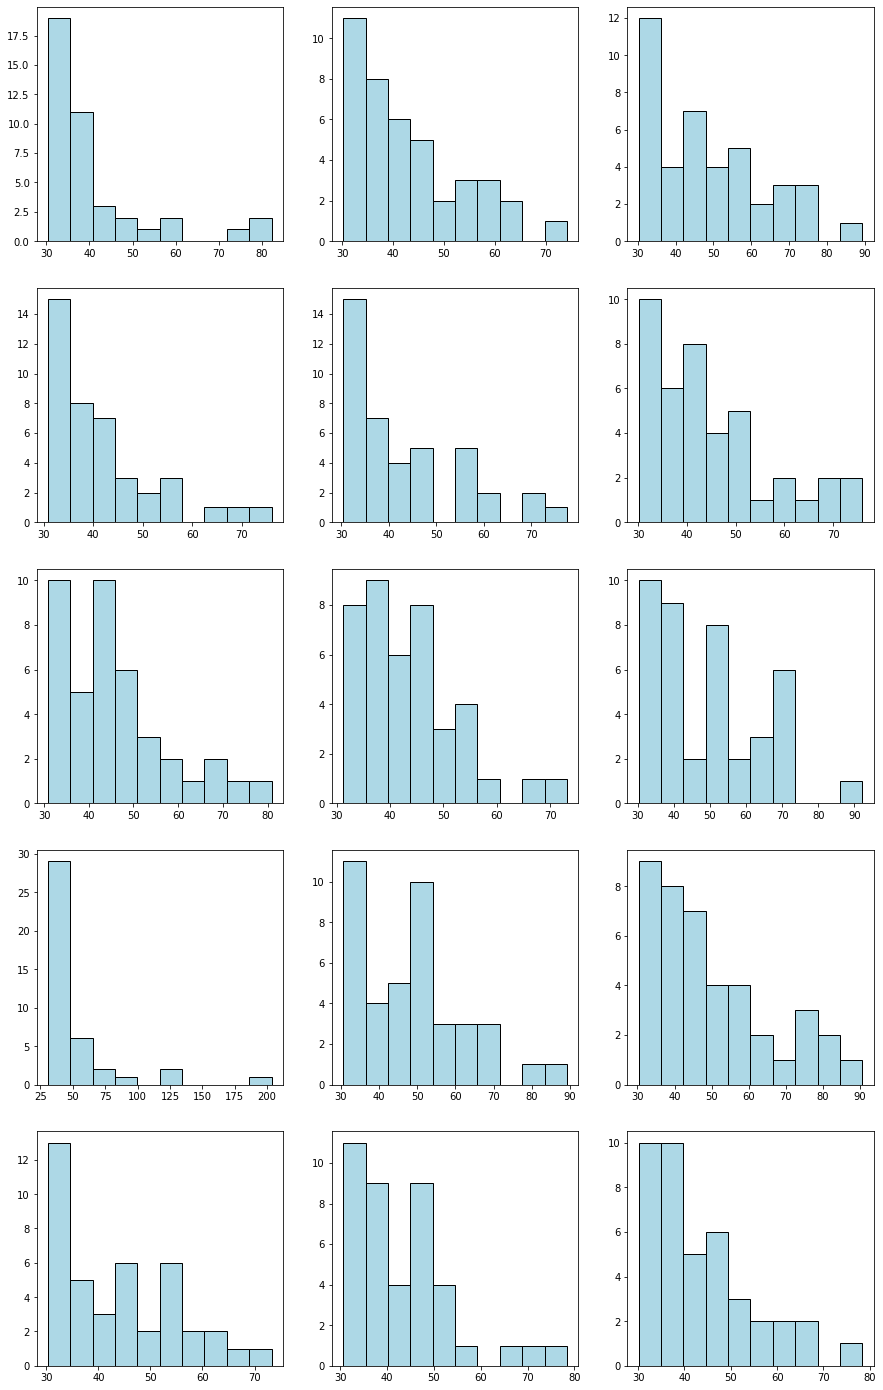

In [11]:
nb_plots = 5
fig, ax = plt.subplots(nb_plots, nb_traces, figsize=(15,nb_plots*5))
for i in range(nb_plots):
    for j in range(nb_traces):
        ax[i,j].hist(ppc_list[j]["gpd"][i], bins = 10, edgecolor='black', color = "lightblue")
plt.show()